In [1]:
import matplotlib.pyplot as plt
import datetime
import tilemapbase as tmb

from pluma.stream.georeference import Georeference
from pluma.stream.ubx import _UBX_MSGIDS
from pluma.schema import Dataset

## Notebook plotting
%matplotlib inline
plt.style.use('ggplot')

## Figure export parameters
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
import matplotlib as mpl
mpl.rcParams.update(new_rc_params)


# Set the paths to the dataset and build the dataset

In [2]:
LOAD_FROM_REMOTE = True
root = r"C:\Users\neurogears\Desktop"

stream_root_folder = r'I:\João\Exp_4-outdoor_experiment\OE011\Lisbon_Baixa_sub-OE104011_2024-05-13T141238Z'  # Path to the dataset. Can be local or remote.

dataset = Dataset(stream_root_folder, datasetlabel="FMUL_" + stream_root_folder.split("\\")[-1], georeference= Georeference())  # Create a Dataset object that will contain the ingested data.
dataset.populate_streams(autoload=False)  # Add the "schema" that we want to load to our Dataset. If we want to load the whole dataset automatically, set autoload to True.

if LOAD_FROM_REMOTE:
# To load a single stream, we can set the autoload property to "True" and use the Dataset.reload_streams method. In this case, we will load all streams by default
    if True:
        dataset.streams.EEG.autoload = True
        dataset.streams.UBX.autoload = True
        dataset.reload_streams(force_load=False)
    # For now, we will build the whole dataset:
    else:
        dataset.reload_streams(force_load=True)  # We will just load every single stream at the same time. This might take a while if loading from AWS
        dataset.add_georeference_and_calibrate()
        dataset.export_dataset(filename=f"{root}\dataset.pickle") # We can export the dataset as a .pickle file.

    # Some warnings will be printed if some sensors were not acquired during the experiment. These are normal and can be usually ignored.

# In order to not having to run this routine multiple times, the output of the ingestion can be saved as a pickle file to be loaded later. E.g.:
else:
    dataset = Dataset.import_dataset(f"{root}\dataset.pickle")  # ... and reimport it at a later point.
print(f"Dataset: {dataset} loaded successfully, and {'not' if not dataset.has_calibration else 'sucessfully'} calibrated." )



@(WIN) --> I:\João\Exp_4-outdoor_experiment\OE011\Lisbon_Baixa_sub-OE104011_2024-05-13T141238Z\20240513151232_OE104011_EXP4.nedf
Reading file...
Header information has been correctly retrieved.
Attempting to automatically correct eeg timestamps to harp timestamps...
Done.
Dataset: <pluma.schema.Dataset object at 0x00000220CFB5FE10> loaded successfully, and not calibrated.


## Dataset structure
The Dataset class follows the following structure:
```
Dataset/
├─ rootfolder
├─ datasetlabel
├─ streams/
├─ georeference/
```

 - `rootfolder` and `datasetlabel` are properties that store the location and label of the dataset, respectively.
 - `streams` is a `DotMap` structure with the initialized schema and, if loaded, all the data. The data of each stream can be generally accessed using `dataset.Stream.data`. Additionally, the Streams can be easily navigated using the "." (dot) notation to access different, potentially nested, relevant fields.
 - `georeference` stores the DataFrame necessary to "geotag" sensor data (*i.e.* to cross-reference in time)

Empty DataFrame
Columns: [Seconds, Value]
Index: []


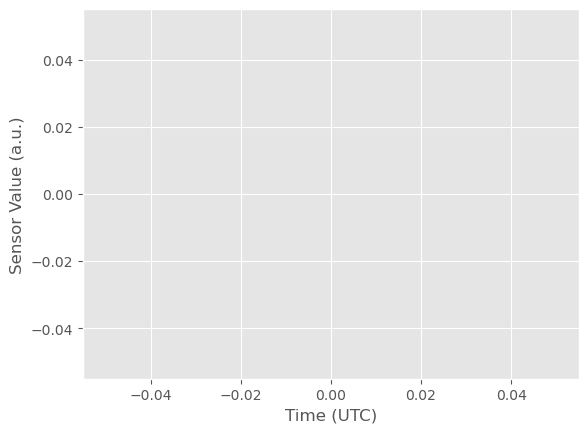

In [7]:
#Visualize the data from a sensor:
SensorData = dataset.streams.BioData.ECG #  Reference one arbitrary sensor data
# Most of the data is in a DataFrame format. Indexed by a column that indicates the time at which the sample was acquired.
print(SensorData.data.head(5))
plt.figure()
plt.plot(SensorData.data)
plt.xlabel("Time (UTC)")
plt.ylabel("Sensor Value (a.u.)")
plt.show()

In [8]:
# For simplicity a general method can be used to attempt to plot the data inside a stream:
dataset.streams.TK.Humidity.Humidity.plot()

ValueError: Input dataframe is empty.

## Visualization:

We are not in a position where we can visualize data in both time and space. The following cells will demo this affordance.

In [9]:
# The first time you run tilemapbase library, you will need to initiate a cache structure
# Initialize tilemapbase cache (run this only once)
if False:
    import tilemapbase as tmb
    tmb.init(create=True)

ValueError: xmin < xmax.

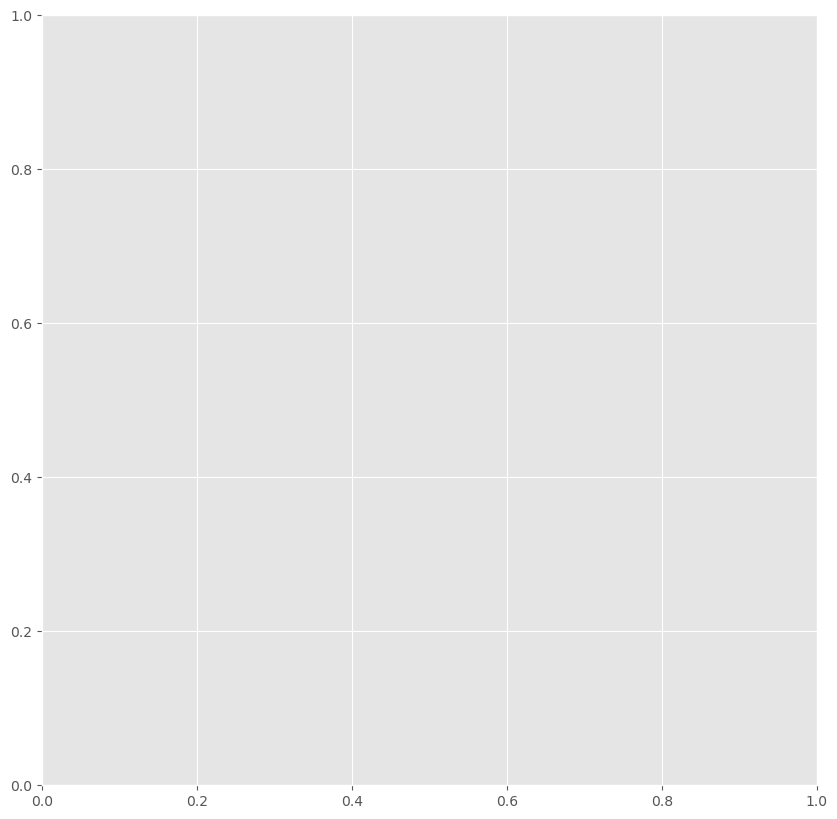

In [10]:
# First we will plot the spatial data colorcoded by time

fig = dataset.showmap(colorscale_override=dataset.georeference.spacetime.index,
                      cmap = "jet",
                      markersize= 5, figsize = (10,10)
                      )
fig.get_axes()[0].set_title(dataset.datasetlabel)
fig.show()

In [ ]:
from pluma.preprocessing.resampling import resample_temporospatial
from pluma.export.maps import showmap

# resample_temporospatial() resamples data in time and space using a dataset georeference. By default, it resamples the data to 2s bins

resampled = resample_temporospatial(dataset.streams.TK.AirQuality.Temperature.data,
                                    dataset.georeference,
                                    sampling_dt=datetime.timedelta(seconds = 2))


tiles = tmb.tiles.Stamen_Watercolour # We can change how the map looks by passing an optional "tiles" argument
fig = showmap(resampled,
              figsize=(10,10),
              tiles=tiles)
fig.get_axes()[0].set_title(dataset.datasetlabel)
fig.show()

In [11]:
# Sometimes additional preprocessing might be required. As an example, when calculating heart rate from the ECG raw signal.

from pluma.preprocessing.ecg import heartrate_from_ecg

hr,_ = heartrate_from_ecg(dataset.streams.BioData.ECG,
                                         fs = 250, max_heartrate_bpm = 250.0,
                                        peak_height = 800, smooth_win = 10) ## Calculates HR from ecg raw signal

resampled = resample_temporospatial(hr, dataset.georeference,
                                           sampling_dt = datetime.timedelta(seconds = 4)) #Resample
fig = showmap(resampled, figsize=(10,10), cmap = 'brg', markersize = 20 ,
                                           tiles = tmb.tiles.Stamen_Toner_Hybrid)
fig.get_axes()[0].set_title(dataset.datasetlabel)
fig.show()

## Plot it in time for comparison
fig, axs = plt.subplots(2,2)
fig.set_size_inches((10,4))
axs[0,0].plot(resampled.Data,  c = [0.1, 0.1, 0.1], lw = 0.5)
axs[0,0].set_xlabel('Time')
axs[0,0].set_ylabel('HR (BPM)')

axs[0,1].plot(dataset.streams.Accelerometer.data["Accl.X"], c = [0.1, 0.1, 0.1], lw = 0.5)
axs[0,1].set_xlabel('Time')
axs[0,1].set_ylabel('Acceleration (G)')

## Plot it in time for comparison
axs[1,0].plot(dataset.streams.TK.AirQuality.Temperature.data/100,  c = [0.1, 0.1, 0.1], lw = 0.5)
axs[1,0].set_xlabel('Time')
axs[1,0].set_ylabel('Temperature (C)')

axs[1,1].plot(dataset.streams.Accelerometer.data["Orientation.X"],  c = [0.1, 0.1, 0.1], lw = 0.5)
axs[1,1].set_xlabel('Time')
axs[1,1].set_ylabel('Torso orientation (Deg)')

fig.show()

KeyError: 'Value0'

In [ ]:
## Comparison of HR given by Empatica and raw ECG signal:
plt.figure(figsize=(15,6))
plt.plot(hr, label = 'ECG')
plt.plot(dataset.streams.Empatica.data.E4_Hr['Value'], label = 'Empatica')
plt.xlabel("Time")
plt.ylabel("HR(bpm)")
plt.legend()
plt.show()

In [ ]:
dataset.streams.Empatica.data.R

In [ ]:
## Export streams to csv
dataset.streams.TK.AirQuality.Temperature.export_to_csv("root")
